## Part 1: Dataset

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [2]:
# Test if GPU is available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
import glob
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, Subset

class VideoDataset(Dataset):
    def __init__(self, root_dir, seq_len=16, transform=None):
        self.root_dir = root_dir
        self.seq_len = seq_len
        self.transform = transform
        
        # Map class names to numeric labels
        classes = sorted(entry.name for entry in os.scandir(root_dir) if entry.is_dir())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        
        # Build a list of all videos: each as (video_id, [frame_paths], label)
        self.video_list = []
        for cls_name in classes:
            cls_dir = os.path.join(root_dir, cls_name)
            # Find all images in this class folder
            all_imgs = glob.glob(os.path.join(cls_dir, '*.jpg'))
            # Group images by video ID prefix (e.g. '001' in '001_frame0.jpg')
            groups = {}
            for img_path in all_imgs:
                filename = os.path.basename(img_path)
                # Assume video ID is everything before first underscore
                vid = filename.split('_')[0]
                groups.setdefault(vid, []).append(img_path)
            # Convert each group to (video_id, sorted_paths, label)
            for vid, frame_paths in groups.items():
                # Sort frames by numeric index after 'frame'
                frame_paths.sort(key=lambda x: int(os.path.splitext(x)[0].split('_frame')[-1]))
                label = self.class_to_idx[cls_name]
                self.video_list.append((vid, frame_paths, label))
        
        # Optionally, sort video_list by video ID or shuffle as needed
        self.video_list.sort(key=lambda x: x[0])  # sort by video_id (string)
    
    def __len__(self):
        return len(self.video_list)
    
    def __getitem__(self, idx):
        vid, frame_paths, label = self.video_list[idx]
        selected_paths = frame_paths

        # Load images and apply transforms
        frames = []
        for img_path in selected_paths:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img) 
            else:
                img = transforms.ToTensor()(img)
            frames.append(img)
        # Stack into a tensor of shape (T, C, H, W)
        video_tensor = torch.stack(frames, dim=0).to(device)
        return video_tensor, label

In [4]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224)),
    transforms.CenterCrop(224),
    transforms.RandomGrayscale(p=0.15),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 2.0)),
    transforms.ToTensor(),
])

# Instantiate dataset
dataset = VideoDataset(root_dir="cnn-lstm-project-5", seq_len=24, transform=transform)

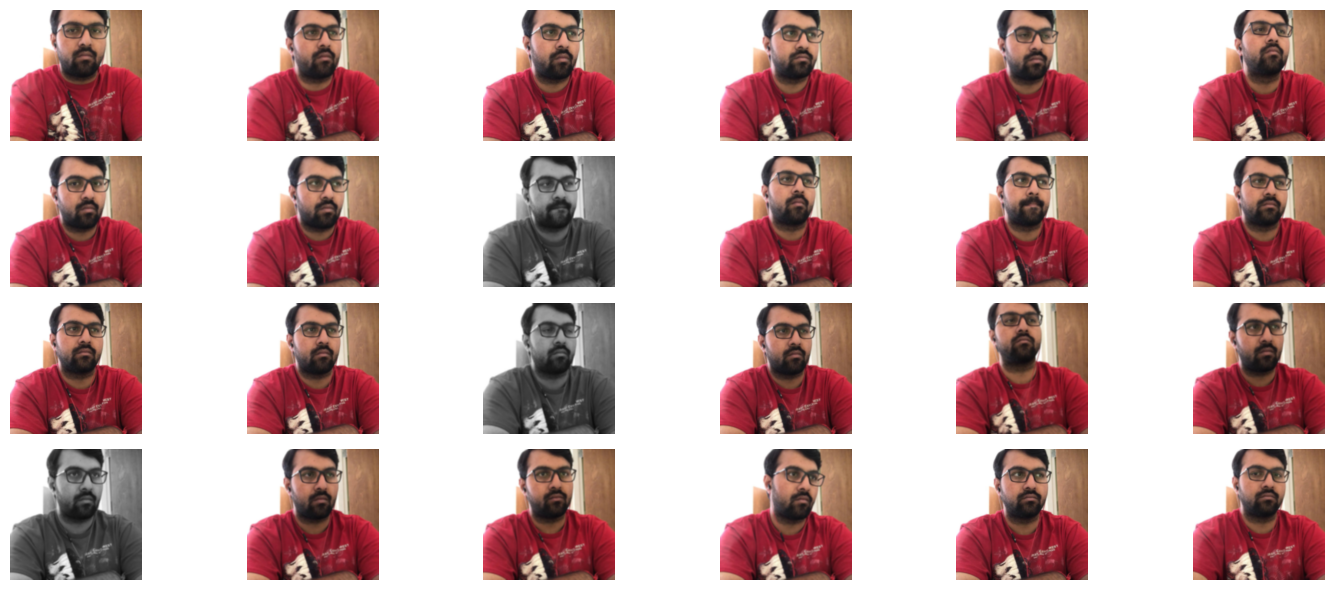

In [5]:
import matplotlib.pyplot as plt

# Get a single video and label from the dataset
video_tensor, label = dataset[0] 

# video_tensor shape: (T, C, H, W)
T = video_tensor.shape[0]

# Plot all frames in a grid (e.g., 6x4 for 24 frames)
cols = 6
rows = (T + cols - 1) // cols
plt.figure(figsize=(15, 6))
for i in range(T):
    plt.subplot(rows, cols, i + 1)
    frame = video_tensor[i].permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    plt.imshow(frame)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Defining the training loop and model evaluation functions
from torch.amp import GradScaler, autocast

torch.backends.cuda.matmul.allow_tf32 = True

scaler = GradScaler()

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        y = y.to(device).float()
        with autocast(device_type="cuda", dtype=torch.float16):
            pred = model(X.to(device))
            loss = loss_fn(pred, y)

        # Backpropagation - modified to use mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        predicted_classes = (pred > 0).float()
        correct += (predicted_classes == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    correct /= size
    print(f"Training Accuracy: {(100*correct):>0.1f}%")
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(device).float()
            # Using mixed precision for testing
            with autocast(device_type="cuda", dtype=torch.float16):
                pred = model(X.to(device))
                test_loss += loss_fn(pred, y).item()

            predicted_classes = (pred > 0).float()
            correct += (predicted_classes == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


## Model 1: Custom

Last Recorded Training Accuracy: 97.9%

Last Recorded Testing Accuracy: 95.8%

In [7]:
# From Model 1 Attempt 10, I added changes to the model architecture
# I decided to use Conv3D instead of Conv2D, where the additional dimension is the sequence
from torch.nn.utils.parametrizations import weight_norm

class NeuralNetwork_Hyper(nn.Module):
    def __init__(self, lstm_h=64):
        super().__init__()
        self.cnn_layer = nn.Sequential(
            weight_norm(nn.Conv3d(3, 16, 3, bias=False, padding=1)),
            nn.GroupNorm(8, 16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            weight_norm(nn.Conv3d(16, 16, 3, bias=False, padding=1, groups=2)),
            nn.GroupNorm(8, 16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            weight_norm(nn.Conv3d(16, 32, 3, bias=False, padding=1, groups=2)),
            nn.GroupNorm(8, 32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            weight_norm(nn.Conv3d(32, 32, 3, bias=False, padding=1, groups=2)),
            nn.GroupNorm(8, 32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            weight_norm(nn.Conv3d(32, 64, 3, bias=False, padding=1, groups=2)),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            weight_norm(nn.Conv3d(64, 64, 3, bias=False, padding=1, groups=2)),
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            weight_norm(nn.Conv3d(64, 128, 3, bias=False, padding=1, groups=2)),
            nn.GroupNorm(8, 128),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Dropout(0.3),
        )
        self.lstm_layer = nn.LSTM(input_size=128, hidden_size=lstm_h, num_layers=3,
                                  dropout=0.3, batch_first=True)
        self.fc_layer = nn.Linear(lstm_h, 1)

    def forward(self, x):
        # Reshape for CNN input
        batch_size, sequence, channels, height, width = x.size()
        x = x.view(batch_size, channels, sequence, height, width)
        x = self.cnn_layer(x)


        # Reshape for LSTM input
        x = x.view(batch_size, sequence, -1)
        output, (h_n, c_n) = self.lstm_layer(x)
        logits = self.fc_layer(h_n[-1])
        return logits.squeeze(1)

model = NeuralNetwork_Hyper().to(device)
print(model)

NeuralNetwork_Hyper(
  (cnn_layer): Sequential(
    (0): ParametrizedConv3d(
      3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _WeightNorm()
        )
      )
    )
    (1): GroupNorm(8, 16, eps=1e-05, affine=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): ParametrizedConv3d(
      16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=2, bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _WeightNorm()
        )
      )
    )
    (5): GroupNorm(8, 16, eps=1e-05, affine=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): ParametrizedConv3d(
      16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=2, bias=False

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold

# Enabling NVIDIA cuDNN auto-tuner
torch.backends.cudnn.benchmark = True

num_videos = len(dataset)
video_indices = np.arange(num_videos)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
batch_size = 8
num_epochs = 9
learning_rate = 5e-4

for fold, (train_idx, test_idx) in enumerate(kf.split(video_indices)):
    print(f"\n===== Fold {fold+1} =====")
    train_set = Subset(dataset, train_idx)
    test_set = Subset(dataset, test_idx)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Re-initialize optimizer, scheduler for each fold
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loop(train_loader, model, loss_fn, optimizer)
        test_loop(test_loader, model, loss_fn)
        scheduler.step()
print("Training complete.")


===== Fold 1 =====
Epoch 1/9
loss: 0.692042  [    8/   96]
Training Accuracy: 45.8%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.695746 

Epoch 2/9
loss: 0.701688  [    8/   96]
Training Accuracy: 51.0%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.694834 

Epoch 3/9
loss: 0.700801  [    8/   96]
Training Accuracy: 51.0%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.694855 

Epoch 4/9
loss: 0.698415  [    8/   96]
Training Accuracy: 51.0%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.694861 

Epoch 5/9
loss: 0.681299  [    8/   96]
Training Accuracy: 51.0%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.697382 

Epoch 6/9
loss: 0.688011  [    8/   96]
Training Accuracy: 51.0%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.694425 

Epoch 7/9
loss: 0.695136  [    8/   96]
Training Accuracy: 42.7%
Test Error: 
 Accuracy: 66.7%, Avg loss: 0.689088 

Epoch 8/9
loss: 0.682717  [    8/   96]
Training Accuracy: 51.0%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.692825 

Epoch 9/9
loss: 0.672252  [    8/   96]
Trai

In [9]:
# Saving the model weights as reference
torch.save(model.state_dict(), "model1_newer_weights.pth")

## Model 2: EfficientNet

Last Recorded Training Accuracy: 97.9%

Last Recorded Testing Accuracy: 95.8%

In [7]:
class CustomFineTuneModel(nn.Module):
    def __init__(self, base_model):
        super(CustomFineTuneModel, self).__init__()
        self.base_model = base_model
        self.lstm_layer = nn.LSTM(input_size=1280, hidden_size=64, batch_first=True)
        self.final_classifier = nn.Linear(64, 1) 

    def forward(self, x):
        batch_size, sequence, channels, height, width = x.size()
        x = x.view(batch_size * sequence, channels, height, width)
        x = self.base_model(x)
        
        x = x.view(batch_size, sequence, -1)  # Reshape for LSTM input
        output, (h_n, c_n) = self.lstm_layer(x)
        x = self.final_classifier(h_n.squeeze(0))
        return x.squeeze()

# Create an instance of the custom model
model2_ft1 = models.efficientnet_v2_s(weights='DEFAULT')
model2_ft1.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [8]:
# For Fixed Feature Extraction

for param in model2_ft1.parameters():
    param.requires_grad = False  # Freeze all layers

In [9]:
model2_ft1.classifier = nn.Identity()  # Remove the final classification layer
model2_ft1 = CustomFineTuneModel(model2_ft1).to(device)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold

# Enabling NVIDIA cuDNN auto-tuner
torch.backends.cudnn.benchmark = True

num_videos = len(dataset)
video_indices = np.arange(num_videos)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
batch_size = 8
num_epochs = 9
learning_rate = 1e-4

for fold, (train_idx, test_idx) in enumerate(kf.split(video_indices)):
    print(f"\n===== Fold {fold+1} =====")
    train_set = Subset(dataset, train_idx)
    test_set = Subset(dataset, test_idx)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Re-initialize optimizer, scheduler for each fold
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model2_ft1.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loop(train_loader, model2_ft1, loss_fn, optimizer)
        test_loop(test_loader, model2_ft1, loss_fn)
        scheduler.step()
print("Training complete.")

# Training took 30m 40s


===== Fold 1 =====
Epoch 1/9
loss: 0.728157  [    8/   96]
Training Accuracy: 53.1%
Test Error: 
 Accuracy: 58.3%, Avg loss: 0.694356 

Epoch 2/9
loss: 0.665094  [    8/   96]
Training Accuracy: 64.6%
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.686462 

Epoch 3/9
loss: 0.627691  [    8/   96]
Training Accuracy: 68.8%
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.702235 

Epoch 4/9
loss: 0.674762  [    8/   96]
Training Accuracy: 64.6%
Test Error: 
 Accuracy: 37.5%, Avg loss: 0.722610 

Epoch 5/9
loss: 0.614576  [    8/   96]
Training Accuracy: 78.1%
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.725079 

Epoch 6/9
loss: 0.604136  [    8/   96]
Training Accuracy: 77.1%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.721432 

Epoch 7/9
loss: 0.524818  [    8/   96]
Training Accuracy: 75.0%
Test Error: 
 Accuracy: 37.5%, Avg loss: 0.757558 

Epoch 8/9
loss: 0.537175  [    8/   96]
Training Accuracy: 77.1%
Test Error: 
 Accuracy: 41.7%, Avg loss: 0.775907 

Epoch 9/9
loss: 0.578967  [    8/   96]
Trai

In [12]:
# Save the model weights as reference
torch.save(model2_ft1.state_dict(), "model2_newer_weights.pth")

## Model 3: ShuffleNet

Last Recorded Training Accuracy: 99%

Last Recorded Testing Accuracy: 95.8%

In [6]:
from torchvision import models

model_3 = models.shufflenet_v2_x1_5(weights='DEFAULT') # Using the 1.5x output channel model
model_3.to(device)

model_3

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_

In [7]:
# FOR Fixed Feature Extraction

for param in model_3.parameters():
    param.requires_grad = False  # Freeze all layers

In [8]:
class CustomFineTuneModel(nn.Module):
    def __init__(self, base_model):
        super(CustomFineTuneModel, self).__init__()
        self.base_model = base_model
        self.lstm_layer = nn.LSTM(input_size=1024, hidden_size=128, batch_first=True) # add dropout
        self.final_classifier = nn.Linear(128, 1) 

    def forward(self, x):
        batch_size, sequence, channels, height, width = x.size()
        x = x.view(batch_size * sequence, channels, height, width)
        x = self.base_model(x)
        
        x = x.view(batch_size, sequence, -1)  # Reshape for LSTM input
        output, (h_n, c_n) = self.lstm_layer(x)
        x = self.final_classifier(h_n[-1])
        return x.squeeze(-1)

# Create an instance of the custom model


model_3.fc = nn.Identity()  # Remove the final classification layer
model3_ft1 = CustomFineTuneModel(model_3).to(device)
# Show the model architecture
model3_ft1

CustomFineTuneModel(
  (base_model): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 88, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.model_selection import KFold

# Enabling NVIDIA cuDNN auto-tuner
torch.backends.cudnn.benchmark = True

num_videos = len(dataset)
video_indices = np.arange(num_videos)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
batch_size = 8
num_epochs = 9
learning_rate = 1e-4

for fold, (train_idx, test_idx) in enumerate(kf.split(video_indices)):
    print(f"\n===== Fold {fold+1} =====")
    train_set = Subset(dataset, train_idx)
    test_set = Subset(dataset, test_idx)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    # Re-initialize optimizer, scheduler for each fold
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model3_ft1.parameters(), lr=learning_rate)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=3)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loop(train_loader, model3_ft1, loss_fn, optimizer)
        test_loop(test_loader, model3_ft1, loss_fn)
        scheduler.step()
print("Training complete.")

# Training took 28m 48.5s


===== Fold 1 =====
Epoch 1/9
loss: 0.749932  [    8/   96]
Training Accuracy: 44.8%
Test Error: 
 Accuracy: 37.5%, Avg loss: 0.697927 

Epoch 2/9
loss: 0.677962  [    8/   96]
Training Accuracy: 59.4%
Test Error: 
 Accuracy: 58.3%, Avg loss: 0.691181 

Epoch 3/9
loss: 0.654972  [    8/   96]
Training Accuracy: 61.5%
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.690983 

Epoch 4/9
loss: 0.694484  [    8/   96]
Training Accuracy: 61.5%
Test Error: 
 Accuracy: 41.7%, Avg loss: 0.704080 

Epoch 5/9
loss: 0.646939  [    8/   96]
Training Accuracy: 69.8%
Test Error: 
 Accuracy: 45.8%, Avg loss: 0.693278 

Epoch 6/9
loss: 0.646348  [    8/   96]
Training Accuracy: 71.9%
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.698807 

Epoch 7/9
loss: 0.667730  [    8/   96]
Training Accuracy: 78.1%
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.708043 

Epoch 8/9
loss: 0.662325  [    8/   96]
Training Accuracy: 75.0%
Test Error: 
 Accuracy: 54.2%, Avg loss: 0.703761 

Epoch 9/9
loss: 0.622388  [    8/   96]
Trai

In [10]:
# Saving the model weights as reference
torch.save(model3_ft1.state_dict(), "model3_newer_weights.pth")